<a href="https://colab.research.google.com/github/sudeepmenon17/PytorchforNN/blob/main/AirfoilS809_SAmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [97]:
!pip install google-auth

In [98]:
from google.colab import auth
from google.colab import drive

In [99]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [100]:
# !ls /content/drive/MyDrive/


In [101]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [102]:
# Create a Model class
class Model(nn.Module):
  def __init__(self,in_features=6, h1 = 61, h2 = 60, out_features=1):
    super().__init__()
    self.fc1 = nn.Linear(in_features,h1)
    self.fc2 = nn.Linear(h1,h2)
    # self.fc3 = nn.Linear(h2,h3)
    self.out = nn.Linear(h2,out_features)

  def forward(self,x):
    x = F.sigmoid(self.fc1(x))
    x = F.relu(self.fc2(x))
    # x = F.leaky_relu(self.fc3(x))
    x = self.out(x)

    return x

In [103]:
# torch.manual_seed(42)

model = Model()

In [104]:
# Read the data set -  Airfoil S809
df1 = pd.read_csv("/content/drive/MyDrive/data_set1.csv")
df2 = pd.read_csv("/content/drive/MyDrive/data_set2.csv")
df3 = pd.read_csv("/content/drive/MyDrive/data_set3.csv")
df4 = pd.read_csv("/content/drive/MyDrive/data_set4.csv")


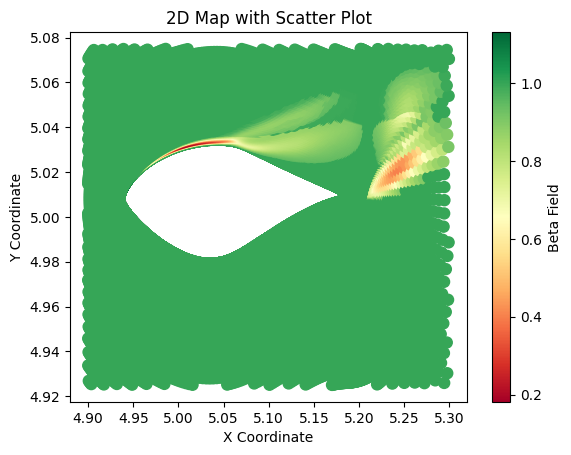

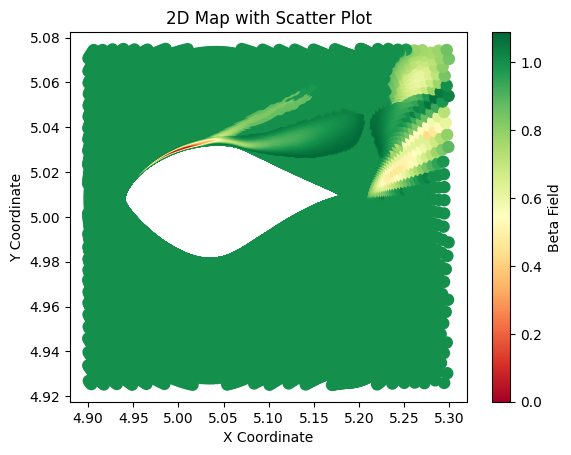

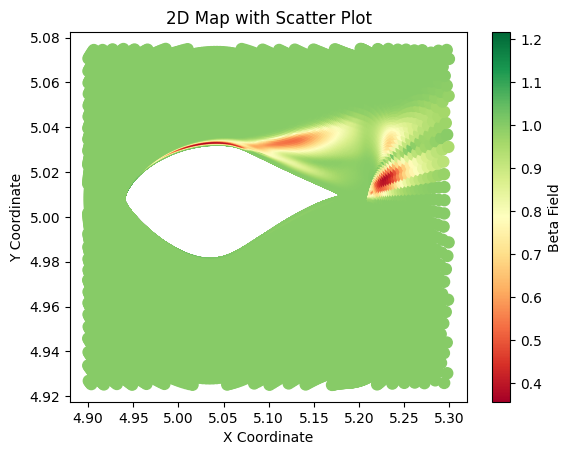

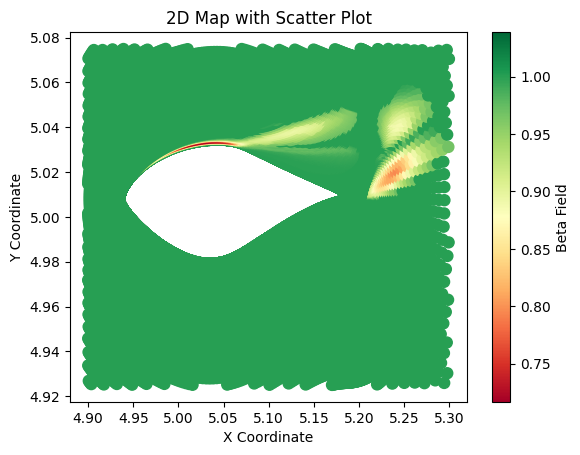

In [105]:
# Combine data
frames = [df1, df2, df3, df4]
ff = []

for item in frames:
  xc = np.array(item['x'])
  yc = np.array(item['y'])
  b = np.array(item['beta'])
  b1 = []


  # Normalize x and y coordinates
  min_range = -5.0
  max_range = 5.0
  xc = (xc - np.min(xc)) * (max_range - min_range) / (np.max(xc) - np.min(xc))
  yc = (yc - np.min(yc)) * (max_range - min_range) / (np.max(yc) - np.min(yc))


  # #####################################################################
  # # Cleaning the beta field in the wake region
  # for k in range(len(xc)):
  #   if xc[k] >= 5.2 and xc[k] <= 5.3:
  #     if yc[k] >= 4.94 and yc[k] <= 4.96:
  #       b1.append(b[k])

  # for j in range(len(xc)):
  #   if xc[j] > 5.15 or yc[j]>5.04:
  #     b[j] = np.mean(b1)

  modified_data = {
    'x': np.array(xc),
    'y': np.array(yc),
    'beta': np.array(b),
    'feature1': np.array(item['feature1']),
    'feature2': np.array(item['feature2']),
    'feature3': np.array(item['feature3']),
    'feature4': np.array(item['feature4']),
    'feature5': np.array(item['feature5']),
    'feature6': np.array(item['feature6'])
  }

  item = pd.DataFrame(modified_data)

  ff.append(item)

  # #####################################################################
  # Plotting cleaned data
  ################################
  nx = []
  ny = []
  nb = []


  # Filter data for the specified range of coordinates
  for i in range(len(xc)):
    if xc[i]>=4.9 and xc[i]<=5.3:
      if yc[i]>=4.925 and yc[i]<=5.075:
        nx.append(xc[i])
        ny.append(yc[i])
        nb.append(b[i])

  # Create a scatter plot
  plt.scatter(nx, ny, c=nb,  cmap= 'RdYlGn',alpha=1, marker='.',s=250)
  plt.colorbar(label='Beta Field')
  plt.xlabel('X Coordinate')
  plt.ylabel('Y Coordinate')
  plt.title('2D Map with Scatter Plot')
  plt.show()
###############################################################################

df = pd.concat(ff)

# # # df
# # Data for beta>1.02 or beta<0.98
# df_filtered = df[(df['beta'] > 1.000) | (df['beta'] < 0.9999)]

df_filtered = df[((df['x'] >=4.95) & (df['x'] <= 5.20) & (df['y'] >= 5.01) & (df['y'] <=5.03)) | df['beta'] <= 1.5]



In [106]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import RobustScaler


# Preprocess Features
df1 = df_filtered.drop(['x','y','beta'],axis=1)
df2 = df_filtered.drop(['x','y','feature1','feature2','feature3','feature4','feature5','feature6'],axis=1)


# Fill missing values with the mean
df1 = df1.fillna(df1.mean())


# Standardization
standard_scaler = StandardScaler()
min_max_scaler = MinMaxScaler(feature_range=(-4, 2))
transformer = Normalizer()
scaler = RobustScaler(with_centering=False)

# Features
X = scaler.fit_transform(df1)

# Target
# y = df_filtered['beta'].values
# y = standard_scaler.fit_transform(df2)
y = min_max_scaler.fit_transform(df2)
# y = scaler.fit_transform(df2)


In [107]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.001,weight_decay=0.01)
# optimizer = torch.optim.SGD(model.parameters(),lr = 0.001,weight_decay=0.01)

In [108]:
#5-Fold Cross Validation
from sklearn import metrics

from sklearn.model_selection import KFold
kFold=KFold(n_splits=5,shuffle=True, random_state=100)

# Initialize a list to store the evaluation scores
scores = []
training_cost = []
testing_cost =[]
iterations = 100
train_fold = [[] for i in range(5)]
test_fold = [[] for i in range(5)]
c = 0
for train_index,test_index in kFold.split(X):
  print("Train Index: ", train_index, "\n")
  print("Test Index: ", test_index)
  print("Size of training data:", len(train_index),"\n")
  print("Size of testing data:", len(test_index),"\n")

  X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]


  X_train = torch.FloatTensor(X_train)
  X_test = torch.FloatTensor(X_test)

  y_train = torch.FloatTensor(y_train)
  y_test = torch.FloatTensor(y_test)


  losses = []
  for i in range(iterations):
    # go forward and predict
    y_pred = model.forward(X_train)

    # Measure the loss
    loss = criterion(y_pred,y_train)

    # Keep track of the losses
    losses.append(loss.detach().numpy())

    # print every 10 epoch
    if i % 10 == 0:
      print(f'iter: {i} and loss: {loss}')

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  train_fold[c].append(y_pred.detach().numpy())
  train_fold[c].append(y_train.detach().numpy())
  training_cost.append(losses)

  # Evaluate Model
  with torch.no_grad():
    y_eval = model.forward(X_test)
    test_loss = criterion(y_eval,y_test)
  test_fold[c].append(y_eval.detach().numpy())
  test_fold[c].append(y_test.detach().numpy())

  testing_cost.append(test_loss)
  scores.append(metrics.mean_squared_error(y_eval,y_test))
  print('MSEloss: {}'.format(testing_cost))
  print('MSE error: {}'.format(scores))

  c = c+1

Train Index:  [     0      1      2 ... 416709 416710 416711] 

Test Index:  [     6     11     12 ... 416702 416705 416708]
Size of training data: 333369 

Size of testing data: 83343 

iter: 0 and loss: 1.2477580308914185
iter: 10 and loss: 0.2888220548629761
iter: 20 and loss: 0.046284519135951996
iter: 30 and loss: 0.0670584887266159
iter: 40 and loss: 0.04108452424407005
iter: 50 and loss: 0.043802596628665924
iter: 60 and loss: 0.04001125320792198
iter: 70 and loss: 0.03995669633150101
iter: 80 and loss: 0.03947552293539047
iter: 90 and loss: 0.039182547479867935
MSEloss: [tensor(0.0402)]
MSE error: [0.040225197]
Train Index:  [     1      2      3 ... 416708 416709 416711] 

Test Index:  [     0      4     15 ... 416703 416704 416710]
Size of training data: 333369 

Size of testing data: 83343 

iter: 0 and loss: 0.0392008014023304
iter: 10 and loss: 0.039009783416986465
iter: 20 and loss: 0.03882701322436333
iter: 30 and loss: 0.038711223751306534
iter: 40 and loss: 0.038624688

Text(0.5, 0, 'Epoch')

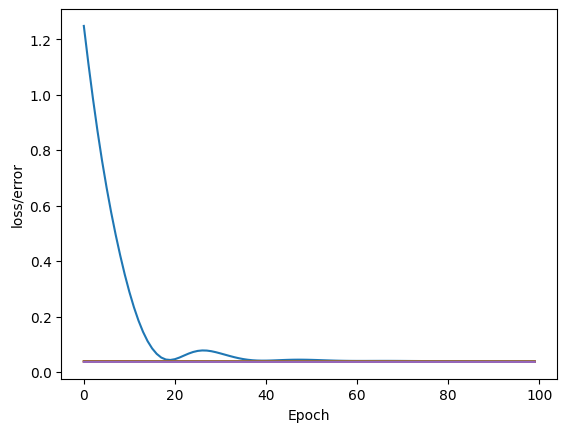

In [109]:
plt.plot(range(iterations), training_cost[0])
plt.plot(range(iterations), training_cost[1])
plt.plot(range(iterations), training_cost[2])
plt.plot(range(iterations), training_cost[3])
plt.plot(range(iterations), training_cost[4])
plt.ylabel("loss/error")
plt.xlabel('Epoch')

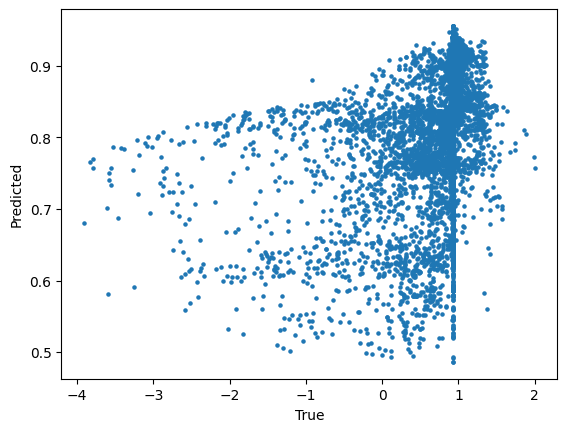

In [110]:
x =test_fold[2][1]
y = test_fold[2][0]
x1 = []
y1 = []
# for i in range(len(x)):
#   # if y[i] < 0.9:
#   #   x1.append(x[i])
#   #   y1.append(y[i])
# min_range = 0
# max_range = 1
# x = (x - np.min(x)) * (max_range - min_range) / (np.max(x) - np.min(x))
# y = (y - np.min(y)) * (max_range - min_range) / (np.max(y) - np.min(y))

plt.scatter(x,y,s =5 )
# plt.scatter(train_fold[1][0],train_fold[1][1], s=5)
plt.xlabel('True')
plt.ylabel('Predicted')
# plt.xlim(0.99999999,1.00000001)

plt.show()
